In [12]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm.auto import tqdm 
import time

In [13]:
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [14]:
with open('dataset/ucf101_2d.pkl', 'rb') as f:
    data = pickle.load(f)

splits = data['split']
annotations = data['annotations']

print(f"Total annotations: {len(annotations)}")
print(f"Splits available: {list(splits.keys())}")

Total annotations: 13320
Splits available: ['train1', 'train2', 'train3', 'test1', 'test2', 'test3']


In [15]:
frame_counts = []
num_persons = []

for ann in annotations:
    keypoints = ann['keypoint']
    frame_counts.append(ann['total_frames'])
    num_persons.append(keypoints.shape[0])

frame_counts = np.array(frame_counts) 
num_persons = np.array(num_persons)

MAX_FRAMES = int(np.percentile(frame_counts, 95))
print(f"95th percentile of frame counts: {MAX_FRAMES}")

95th percentile of frame counts: 359


In [16]:
class UCF101KeypointDataset(Dataset):
    def __init__(self, annotations, video_names, max_frames=119, person_strategy='first', augment=False):
        frame_dir_to_ann = {str(ann['frame_dir']).strip(): ann for ann in annotations}
        
        self.annotations = []
        missing_count = 0
        for video_name in video_names:
            video_name_clean = str(video_name).strip()
            if video_name_clean in frame_dir_to_ann:
                self.annotations.append(frame_dir_to_ann[video_name_clean])
            else:
                missing_count += 1
        
        if missing_count > 0:
            print(f"Warning: {missing_count} videos not found in annotations")
        
        self.max_frames = max_frames
        self.person_strategy = person_strategy
        self.augment = augment
        
        
        
    def __len__(self):
        return len(self.annotations)
    
    def _select_person(self, keypoints, keypoint_scores):
        num_persons = keypoints.shape[0]
        
        if num_persons == 1:
            return keypoints[0], keypoint_scores[0]
        
        if self.person_strategy == 'first':
            return keypoints[0], keypoint_scores[0]
        
        elif self.person_strategy == 'max_conf':
            avg_conf_per_person = keypoint_scores.mean(axis=(1, 2))
            best_person_idx = avg_conf_per_person.argmax()
            return keypoints[best_person_idx], keypoint_scores[best_person_idx]
        
        elif self.person_strategy == 'average':
            weights = keypoint_scores[..., np.newaxis]
            weighted_keypoints = (keypoints * weights).sum(axis=0)
            total_weights = weights.sum(axis=0) + 1e-8
            avg_keypoints = weighted_keypoints / total_weights
            avg_scores = keypoint_scores.mean(axis=0)
            return avg_keypoints, avg_scores
        
        else:
            raise ValueError(f"Unknown person_strategy: {self.person_strategy}")
    
    def __getitem__(self, idx):
        try:
            sample = self.annotations[idx]
            
            keypoints = sample['keypoint']
            keypoint_scores = sample['keypoint_score']
            label = sample['label']
            
            keypoints, keypoint_scores = self._select_person(keypoints, keypoint_scores)
            
            T, num_joints, coords = keypoints.shape
            
            
            if T < self.max_frames:
                pad_frames = self.max_frames - T
                keypoints = np.pad(keypoints, ((0, pad_frames), (0, 0), (0, 0)), mode='constant')
                keypoint_scores = np.pad(keypoint_scores, ((0, pad_frames), (0, 0)), mode='constant')
            else:
                keypoints = keypoints[:self.max_frames]
                keypoint_scores = keypoint_scores[:self.max_frames]
            
            
            features = np.concatenate([keypoints, keypoint_scores[..., np.newaxis]], axis=-1)
            
           
            if self.augment:
                noise = np.random.randn(*features.shape) * 0.01
                features = features + noise
            
            
            features = features.transpose(2, 0, 1)
            
            return torch.FloatTensor(features), torch.LongTensor([label])[0]
        
        except Exception as e:
            print(f"Error loading sample {idx}: {e}")
            return torch.zeros((3, self.max_frames, 17)), torch.LongTensor([0])[0]

In [17]:
class PoseKeypointCNN(nn.Module):
    def __init__(self, num_classes=101, max_frames=119, num_joints=17, in_channels=3):
        super(PoseKeypointCNN, self).__init__()
        
        self.temporal_conv = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=(5, 1), padding=(2, 0)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Conv2d(64, 128, kernel_size=(5, 1), padding=(2, 0)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1)),
            nn.Dropout(0.3),
            
            nn.Conv2d(128, 256, kernel_size=(5, 1), padding=(2, 0)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1)),
            nn.Dropout(0.3)
        )
        
        self.spatial_conv = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(1, 3), padding=(0, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Conv2d(256, 512, kernel_size=(1, 3), padding=(0, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Dropout(0.4)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.temporal_conv(x)
        x = self.spatial_conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [18]:
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
SPLIT_NUM = 1
PERSON_STRATEGY = 'max_conf'
NUM_CLASSES_SUBSET = 5  # Poner "None" para usar todas las clases


train_video_names = splits[f'train{SPLIT_NUM}']
test_video_names = splits[f'test{SPLIT_NUM}']


if NUM_CLASSES_SUBSET is not None:
    print(f"QUICK TRAINING MODE: Using only {NUM_CLASSES_SUBSET} classes")

    
    all_labels = sorted(set([ann['label'] for ann in annotations]))
    selected_classes = all_labels[:NUM_CLASSES_SUBSET]
    
    frame_dir_to_ann = {str(ann['frame_dir']).strip(): ann for ann in annotations}
    
    train_video_names_filtered = []
    for vname in train_video_names:
        vname_clean = str(vname).strip()
        if vname_clean in frame_dir_to_ann:
            if frame_dir_to_ann[vname_clean]['label'] in selected_classes:
                train_video_names_filtered.append(vname)
    
    test_video_names_filtered = []
    for vname in test_video_names:
        vname_clean = str(vname).strip()
        if vname_clean in frame_dir_to_ann:
            if frame_dir_to_ann[vname_clean]['label'] in selected_classes:
                test_video_names_filtered.append(vname)
    
    train_video_names = train_video_names_filtered
    test_video_names = test_video_names_filtered
    
    print(f"Filtered training videos: {len(train_video_names)}")
    print(f"Filtered testing videos: {len(test_video_names)}")


train_dataset = UCF101KeypointDataset(annotations, train_video_names, MAX_FRAMES, 
                                      person_strategy=PERSON_STRATEGY, augment=True)
test_dataset = UCF101KeypointDataset(annotations, test_video_names, MAX_FRAMES, 
                                     person_strategy=PERSON_STRATEGY, augment=False)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                         num_workers=0, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        num_workers=0, pin_memory=False)

train_labels = [ann['label'] for ann in train_dataset.annotations]
num_classes = len(set(train_labels))
print(f"\nNumber of classes: {num_classes}")
print(f"Batches per epoch: {len(train_loader)}")

QUICK TRAINING MODE: Using only 5 classes
Filtered training videos: 461
Filtered testing videos: 183

Number of classes: 5
Batches per epoch: 15


In [19]:
model = PoseKeypointCNN(num_classes=num_classes, max_frames=MAX_FRAMES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

In [20]:
def train_epoch(model, loader, criterion, optimizer, epoch_num):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    pbar = tqdm(loader, desc=f"Epoch {epoch_num} [Train]", leave=True)
    for batch_idx, (features, labels) in enumerate(pbar):
        try:
            features, labels = features.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Update progress bar
            if batch_idx % 2 == 0:
                current_acc = accuracy_score(all_labels, all_preds) if len(all_labels) > 0 else 0
                pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{current_acc:.4f}'})
        
        except Exception as e:
            print(f"\nError in batch {batch_idx}: {e}")
            continue
    
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

def evaluate(model, loader, criterion, epoch_num):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    pbar = tqdm(loader, desc=f"Epoch {epoch_num} [Val]", leave=True)
    with torch.no_grad():
        for features, labels in pbar:
            try:
                features, labels = features.to(device), labels.to(device)
                
                outputs = model(features)
                loss = criterion(outputs, labels)
                
                total_loss += loss.item()
                preds = outputs.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
            
            except Exception as e:
                print(f"\nError in validation: {e}")
                continue
    
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy, all_preds, all_labels

In [21]:
train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_val_acc = 0

print("\n" + "="*50)
print("STARTING TRAINING")
print("="*50)
print(f"Epochs: {NUM_EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Dataset size: {len(train_dataset)} train, {len(test_dataset)} test")

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    
    print(f"\n{'='*50}")
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"{'='*50}")
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, epoch+1)
    val_loss, val_acc, _, _ = evaluate(model, test_loader, criterion, epoch+1)
    
    epoch_time = time.time() - epoch_start
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"\nResults:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}   | Val Acc: {val_acc:.4f}")
    print(f"  Time: {epoch_time:.2f}s")
    
    scheduler.step(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), f'best_model_split{SPLIT_NUM}.pth')
        print(f"Saved best model")

total_time = time.time() - start_time
print(f"\n{'='*50}")
print(f"TRAINING COMPLETE!")
print(f"Total time: {total_time/60:.2f} minutes")
print(f"Best val accuracy: {best_val_acc:.4f}")
print(f"{'='*50}")


STARTING TRAINING
Epochs: 10
Batch size: 32
Dataset size: 461 train, 183 test

Epoch 1/10


Epoch 1 [Val]: 100%|██████████| 6/6 [00:01<00:00,  3.20it/s]



Results:
  Train Loss: 1.4592 | Train Acc: 0.3644
  Val Loss: 2.9874   | Val Acc: 0.1749
  Time: 23.91s
Saved best model

Epoch 2/10


Epoch 2 [Val]: 100%|██████████| 6/6 [00:01<00:00,  3.24it/s]



Results:
  Train Loss: 1.1791 | Train Acc: 0.5466
  Val Loss: 1.4460   | Val Acc: 0.3770
  Time: 22.48s
Saved best model

Epoch 3/10


Epoch 3 [Val]: 100%|██████████| 6/6 [00:01<00:00,  3.20it/s]



Results:
  Train Loss: 1.0330 | Train Acc: 0.6204
  Val Loss: 0.9332   | Val Acc: 0.5847
  Time: 22.68s
Saved best model

Epoch 4/10


Epoch 4 [Val]: 100%|██████████| 6/6 [00:01<00:00,  3.17it/s]



Results:
  Train Loss: 0.9105 | Train Acc: 0.6443
  Val Loss: 0.8475   | Val Acc: 0.6339
  Time: 22.61s
Saved best model

Epoch 5/10


Epoch 5 [Val]: 100%|██████████| 6/6 [00:01<00:00,  3.26it/s]



Results:
  Train Loss: 0.8374 | Train Acc: 0.6659
  Val Loss: 0.7293   | Val Acc: 0.6885
  Time: 22.83s
Saved best model

Epoch 6/10


Epoch 6 [Val]: 100%|██████████| 6/6 [00:01<00:00,  3.29it/s]



Results:
  Train Loss: 0.8016 | Train Acc: 0.7028
  Val Loss: 1.1013   | Val Acc: 0.5519
  Time: 22.21s

Epoch 7/10


Epoch 7 [Val]: 100%|██████████| 6/6 [00:01<00:00,  3.24it/s]



Results:
  Train Loss: 0.7146 | Train Acc: 0.7527
  Val Loss: 0.6583   | Val Acc: 0.7377
  Time: 22.14s
Saved best model

Epoch 8/10


Epoch 8 [Val]: 100%|██████████| 6/6 [00:01<00:00,  3.12it/s]



Results:
  Train Loss: 0.7470 | Train Acc: 0.7137
  Val Loss: 1.5808   | Val Acc: 0.5574
  Time: 22.25s

Epoch 9/10


Epoch 9 [Val]: 100%|██████████| 6/6 [00:01<00:00,  3.23it/s]



Results:
  Train Loss: 0.7104 | Train Acc: 0.7527
  Val Loss: 0.6046   | Val Acc: 0.7322
  Time: 22.26s

Epoch 10/10


Epoch 10 [Val]: 100%|██████████| 6/6 [00:01<00:00,  3.19it/s]


Results:
  Train Loss: 0.6037 | Train Acc: 0.7679
  Val Loss: 0.7652   | Val Acc: 0.7158
  Time: 22.38s

TRAINING COMPLETE!
Total time: 3.76 minutes
Best val accuracy: 0.7377


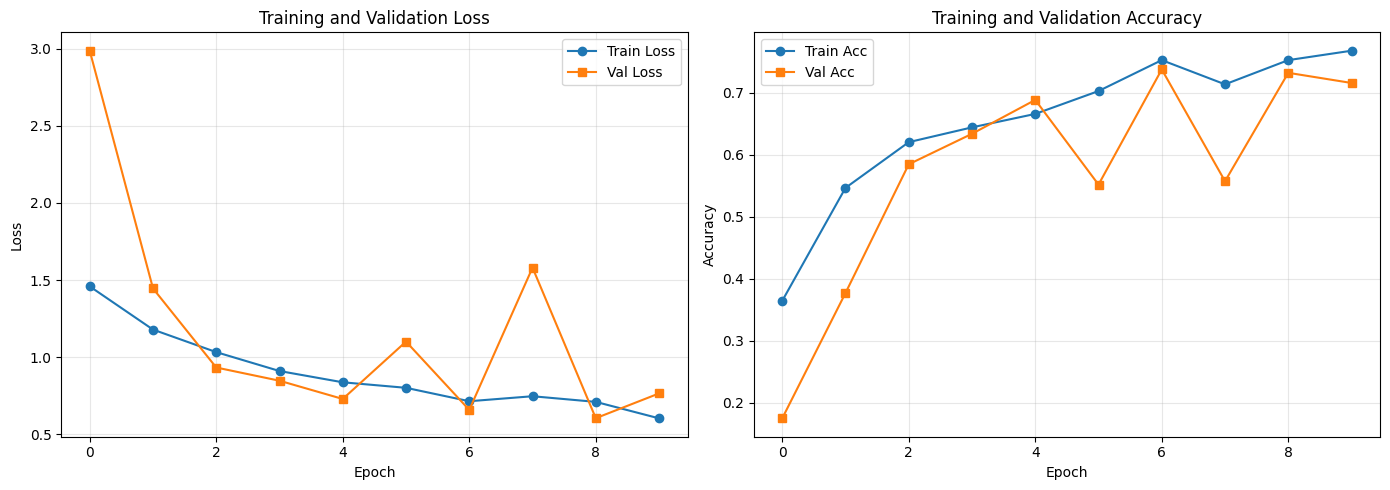

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, label='Train Loss', marker='o')
axes[0].plot(val_losses, label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(train_accs, label='Train Acc', marker='o')
axes[1].plot(val_accs, label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'training_curves_split{SPLIT_NUM}.png', dpi=300, bbox_inches='tight')
plt.show()